# Spatial Lag Model

In [1]:
from esda.moran import Moran
import geopandas as gpd
from libpysal.weights import DistanceBand, KNN
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from splot.esda import plot_moran
import spreg
import sys

sys.path.append("..")
from statshelper import q_q_plot
plt.style.use('dark_background')

In [2]:
df = pd.read_csv("../data/processed/Cleaned_Chicago_Sales.csv")
df.head()

,Unnamed: 0,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Type of Residence,Apartments,Wall Material,Roof Material,...,Bool-Type of Residence-1,Bool-Type of Residence-2,Bool-Type of Residence-4,Bool-Type of Residence-8,Bool-Type of Residence-7,Bool-Type of Residence-6,Bool-Wall Material-2,Bool-Wall Material-3,Bool-Wall Material-1,Bool-Wall Material-4
0,2,16094150130000,211,13,-0.297580,77,3.0,6.0,2.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,5,4252000820000,204,100,2.868180,25,5.0,0.0,2.0,4.0,...,0,0,0,0,0,0,1,0,0,0
2,8,14322110150000,208,12,-0.596010,74,3.0,0.0,2.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,9,27021200080000,204,34,1.698873,28,1.0,0.0,3.0,1.0,...,1,0,0,0,0,0,0,1,0,0
4,11,13121080620000,204,42,0.515768,71,1.0,0.0,2.0,1.0,...,1,0,0,0,0,0,1,0,0,0


In [3]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:26916")

This is a common set of quantitiative variables shared across all of these models. The method is too memory and computation intensive to use on the whole dataset, so we use a random sample of 2.5%:

In [4]:
i_vars = [
    'Age',
    'Bedrooms',  
    'Building Square Feet', 
    'Estimate (Building)', 
    'Estimate (Land)', 
    'Fireplaces', 
    'Full Baths',
    'Garage 1 Area',
    'Garage 2 Area', 
    'Half Baths', 
    'Land Square Feet',
    'Rooms',
    'Sale Quarter'
    ]
dep_var = ['Sale Price']
other_to_keep = ["PIN", "Neighborhood Code", "Town Code", "geometry"]
my_rows = i_vars+dep_var+other_to_keep
gdf = gdf[my_rows]
gdf = gdf.sample(frac=.025, random_state=0)
print("Dataframe has {} rows and {} columns".format(len(gdf), len(list(gdf.columns))))
X = gdf[i_vars].values
y = gdf[dep_var].values.ravel()
gdf.head()

Dataframe has 8107 rows and 18 columns


,Age,Bedrooms,Building Square Feet,Estimate (Building),Estimate (Land),Fireplaces,Full Baths,Garage 1 Area,Garage 2 Area,Half Baths,Land Square Feet,Rooms,Sale Quarter,Sale Price,PIN,Neighborhood Code,Town Code,geometry
255476,-1.090298,-0.292681,-0.780196,-0.213234,-0.668786,-0.599533,-0.891279,-2.100215,-0.041762,1.066654,0.082893,-0.268846,-1.233509,-0.213048,27272130250000,46,28,POINT (430474.445 4604029.943)
4525,-0.771854,-0.292681,-0.318133,-0.419435,-1.613855,-0.599533,-0.891279,-2.100215,-0.041762,1.066654,-2.396135,-0.268846,-0.983113,-1.020361,7072031870000,109,35,POINT (406403.875 4657100.302)
206728,-0.899231,2.583133,2.016681,0.949160,0.117826,-0.599533,2.162552,-2.100215,-0.041762,-0.848209,0.955862,2.906338,0.769658,0.771894,28314100050000,210,13,POINT (435165.992 4601377.469)
251208,-0.453411,-0.292681,-0.731985,0.374207,-0.133190,-0.599533,-0.891279,0.550000,-0.041762,-0.848209,-0.596010,-0.795788,-1.358707,-0.086441,12124070110000,10,26,POINT (432372.275 4647115.837)
172553,0.215320,-0.292681,-0.772410,-0.961504,-0.131889,-0.599533,-0.891279,-2.100215,-0.041762,-0.848209,0.302863,-0.795788,-1.483905,-1.267365,23142080080000,12,30,POINT (431836.962 4616704.122)


Create a weight matrix using k-nearest neighbors.

In [5]:
# determine weight matrix
w = KNN.from_dataframe(gdf, k=64) # needed k large enough that it was connected
#w = DistanceBand.from_dataframe(gdf,threshold=.0075) # needed k large enough that it was connected

Transform the weight matrix to normalize the rows.

In [6]:
w.transform = 'R'

In [7]:
slm = spreg.ML_Lag(y, X, w=w, name_x=i_vars, name_y="Sale Price")

/home/lagrange/.local/lib/python3.8/site-packages/scipy/optimize/_minimize.py:777: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/home/lagrange/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [8]:
print(slm.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  Sale Price                Number of Observations:        8107
Mean dependent var  :     -0.0035                Number of Variables   :          15
S.D. dependent var  :      0.9999                Degrees of Freedom    :        8092
Pseudo R-squared    :      0.7571
Spatial Pseudo R-squared:  0.6710
Sigma-square ML     :       0.243                Log likelihood        :   -5806.859
S.E of regression   :       0.493                Akaike info criterion :   11643.717
                                                 Schwarz criterion     :   11748.725

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

**Note that the random subsample may mean that your results vary from this analysis.**

Looking at the `Probability` row we see that the intercept, `Fireplaces`, `Full Baths`, `Garage 2 Area`, `Land Square Feet` and `Rooms` are statistically insignificant. This is a very high number of statistically insignficant variables compared to OLS and SEM. Ignoring these variables, the only variable with a negative coefficient is `Age`, which makes sense.

Taking a quick look at the models' fit:

* Pseudo $R^2$ is 0.76 which is very high compared to SEM and an improvement on OLS. This means that 76% of the variation in `Sales Price` can be explained by the model.
* The AIC of 11,643.71 is higher than than SEM meaning the Spatial Error Model outperforms Spatial Lag on that front.

Next, let's look at the residuals:

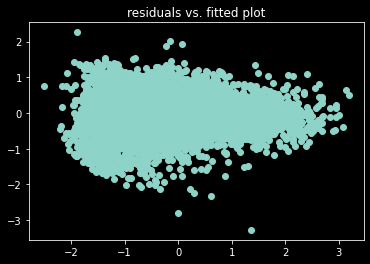

In [9]:
plt.scatter(slm.predy, slm.u)
plt.title("residuals vs. fitted plot")
plt.show()

Now, we can check if the errors are spatially autocorrelated using the Moran's I and map the residuals. The Moran's I of 0.05 is higher than SEM's Moran's I of 0.00, meaning that the errors are more spatially autocorrelated in this model, but still quite low.

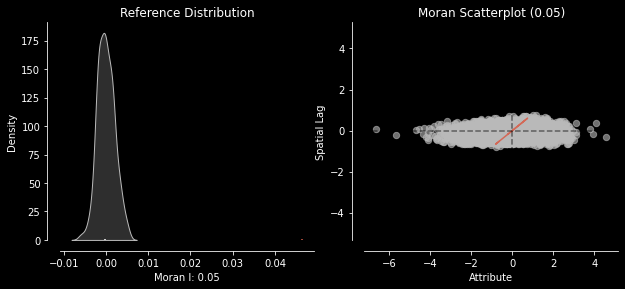

In [10]:
slm_moran = Moran(slm.u, w, permutations=199)
plot_moran(slm_moran, zstandard=True, figsize=(10,4))
plt.show()

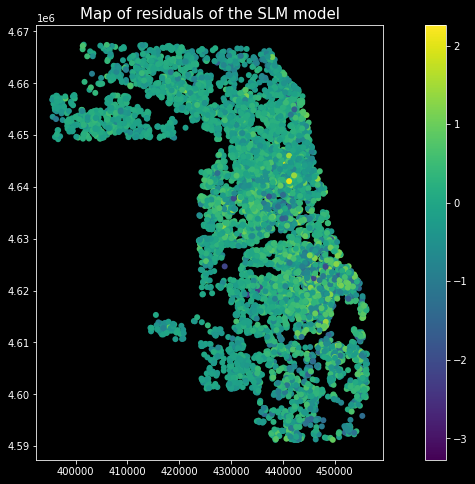

In [11]:
ax = gdf.plot(column=slm.u.reshape(-1),legend=True,figsize=(15,8), linewidth=0.0)
plt.title("Map of residuals of the SLM model",fontsize=15)
plt.show()

## Results from Subsampling

The dataset is too large to run on even a Slurm cluster (requires ~800GB RAM) so I ran the method on 5% of the data over 100 iterations to get an idea of what the results might be. The results are in `data/results/SpatialLagModelResult05.csv`.

In [12]:
res = pd.read_csv("../data/results/SpatialLagModelResult05.csv")
res.head()

,Iteration,AIC,R^2,Moran's I,Age Coefficient,Age Z-Stat,Age Probability,Bedrooms Coefficient,Bedrooms Z-Stat,Bedrooms Probability,...,Half Baths Probability,Land Square Feet Coefficient,Land Square Feet Z-Stat,Land Square Feet Probability,Rooms Coefficient,Rooms Z-Stat,Rooms Probability,Sale Quarter Coefficient,Sale Quarter Z-Stat,Sale Quarter Probability
0,0,23035.704192,0.759469,0.041612,-1.413973,-36.841789,3.958674e-297,-0.096762,-19.992528,6.397170e-89,...,0.230130,0.012874,2.894861,0.003793,0.013917,2.835442,0.004576,-0.013869,-1.559540,0.118869
1,1,23401.725704,0.750701,0.040797,-1.401956,-36.054109,1.189096e-284,-0.110551,-22.214055,2.512134e-109,...,0.369550,0.004115,0.910404,0.362610,0.010391,2.085964,0.036982,-0.000420,-0.045321,0.963851
2,2,23355.397552,0.756926,0.041034,-1.412486,-36.582456,5.437232e-293,-0.104532,-21.412195,1.028525e-101,...,0.255993,0.007771,1.718013,0.085794,0.009334,1.894202,0.058198,0.021024,2.335103,0.019538
3,3,23384.380648,0.753405,0.039577,-1.436832,-37.108781,2.027746e-301,-0.092972,-18.866295,2.159162e-79,...,0.243898,0.011401,2.498823,0.012461,0.009763,1.936832,0.052766,0.016743,1.817238,0.069181
4,4,23345.984972,0.753865,0.041357,-1.369834,-35.305556,4.825722e-273,-0.099830,-20.251267,3.462166e-91,...,0.672854,0.012360,2.715861,0.006610,0.011235,2.291601,0.021929,-0.009486,-1.036696,0.299877


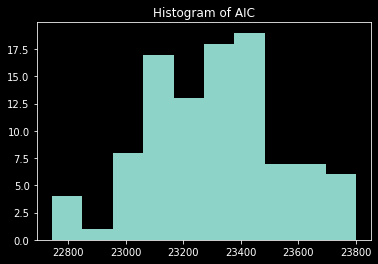

In [13]:
plt.hist(res["AIC"])
plt.title("Histogram of AIC")
plt.show()

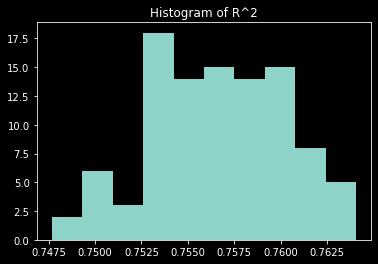

In [14]:
plt.hist(res["R^2"])
plt.title("Histogram of R^2")
plt.show()

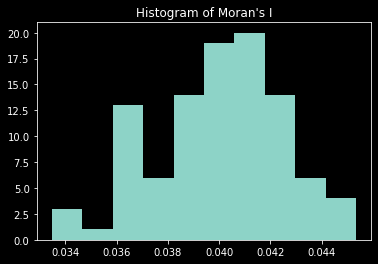

In [15]:
plt.hist(res["Moran's I"])
plt.title("Histogram of Moran's I")
plt.show()

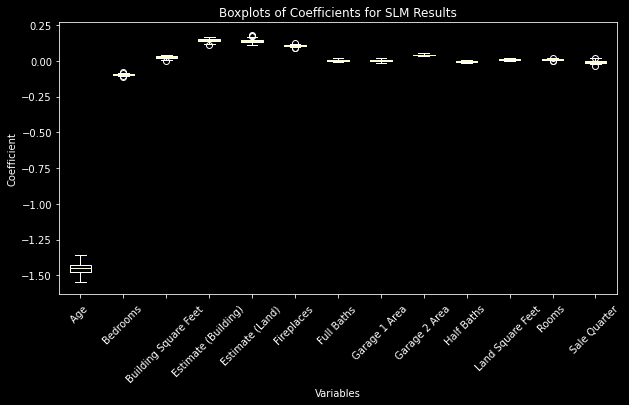

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot([res[column] for column in res.columns if "Coefficient" in column])
ax.set(
    axisbelow=True,
    title="Boxplots of Coefficients for SLM Results",
    xlabel="Variables",
    ylabel="Coefficient"
)
ax.set_xticklabels([column.replace("Coefficient", "") for column in res.columns if "Coefficient" in column], rotation=45)
plt.show()

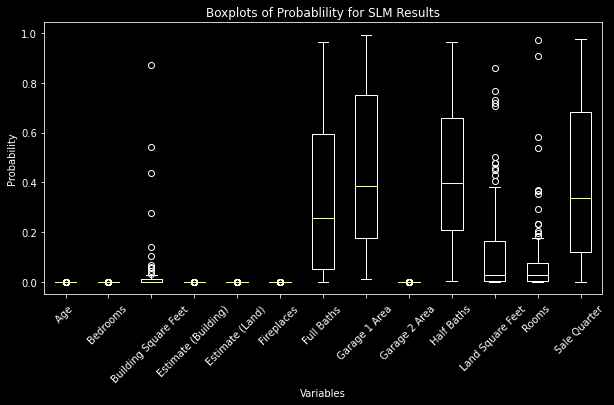

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
ax.boxplot([res[column] for column in res.columns if "Probability" in column])
ax.set(
    axisbelow=True,
    title="Boxplots of Probablility for SLM Results",
    xlabel="Variables",
    ylabel="Probability"
)
ax.set_xticklabels([column.replace("Probability", "") for column in res.columns if "Probability" in column], rotation=45)
plt.show()